# Remarques:

Le notebook ne runnait pas quand j'ai pull
C'est pratique si chacun peut 'Restart the Kernel' avant de push comme ca le code compile pour ceux d'après

# TODO LIST:

cf google doc


# Data loading & cleaning

#### Imports

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

#### Dataset description
In the following analysis, we will analyse the dataset "Wikipedia Vote Network", which can be found on the SNAP website. 
Wikipedia is the free online encyclopedia that we all know and love. Its articles are written by volunteers, amongst whom can be distinguished Administrators. In addition of being able to write articles, those people also have access to technical features of the website, especially giving the ability to help with its maintenance. But not anyone can become an admin that easily ! 
Adminship seekers have go through a public election process at the end of which the vote count determines whether or not they are promoted.  
Our dataset compile the 2794 admin elections that have happened between 2004 and January 2008. In this stretch of time, 103,663 votes were casted by a total of 7,066 users participating in the elections (meaning they either casted a vote or tried being elected). 1,235 elections had a positive outcome, while 1,559 times the adminship seekers were rejected.
About half of the votes in the dataset are by existing admins, while the other half comes from ordinary Wikipedia users.

The network contains all the Wikipedia voting data from the inception of Wikipedia till January 2008. Nodes in the network represent wikipedia users and a directed edge from node i to node j represents that user i voted on user j.

#### Features description

   E: election outcome, succesful (1) or not (0)
   
   T: time election was closed
   
   U: candidate id, the one being considered for promotion
   
   N: nominator id
   
   V: we have 3 interesting features in this line
   
      result of the vote (1:support, 0:neutral, -1:oppose)
      
      voter id
      
      time of the vote (yyyy-mm-dd)


#### Data loading

In [2]:
DATA_PATH = "data/"

# create a variable to store all the features
wiki = []

# we use encoding="latin-1" as some user names contain non utf-8 characters
# note that we are not interested in the user names, so we don't care if their names is not properly read
with open(DATA_PATH+"wikiElec.ElecBs3.txt", encoding="latin-1") as f:
    
    # lines of the files
    for line in f.readlines():
        
        # lines are separated with tab: \t
        line = line.split("\t")
        first = line[0]
            
        # election outcome
        if first=="E":
            elec_outcome = int(line[1][:-1]) #[:-1] to remove the \n
            continue
        
        # time the election was closed
        if first=="T":
            elec_time = pd.to_datetime(line[1])
            continue
            
        # candidate id  
        if first=="U":
            candidate_id = int(line[1])
            continue 
            
        # nominator id
        if first=="N":
            nominator_id = int(line[1])
            continue
        
        if first=="V":
            vote = int(line[1])
            voter_id = int(line[2])
            vote_time = pd.to_datetime(line[3])
            
            #store the results
            wiki.append([elec_outcome, elec_time, candidate_id, voter_id, vote, vote_time, nominator_id])
            continue

In [3]:
# store the result wiki in an appropriate pandas dataframe
wikipedia = pd.DataFrame(wiki, columns = ["elec_outcome", "elec_time", "candidate_id", "voter_id", "vote", "vote_time", "nominator_id"])
wikipedia.head()

,elec_outcome,elec_time,candidate_id,voter_id,vote,vote_time,nominator_id
0,1,2004-09-21 01:15:53,30,3,1,2004-09-14 16:26:00,32
1,1,2004-09-21 01:15:53,30,25,-1,2004-09-14 16:53:00,32
2,1,2004-09-21 01:15:53,30,4,1,2004-09-14 17:08:00,32
3,1,2004-09-21 01:15:53,30,5,1,2004-09-14 17:37:00,32
4,1,2004-09-21 01:15:53,30,6,1,2004-09-14 19:28:00,32


In [4]:
# check for coherent types
wikipedia.dtypes

elec_outcome             int64
elec_time       datetime64[ns]
candidate_id             int64
voter_id                 int64
vote                     int64
vote_time       datetime64[ns]
nominator_id             int64
dtype: object

#### Data cleaning

We would not want to begin our analysis using inexisting dates ! Let us check that all dates present in our dataframe are coherent. 

Let's check extreme dates.

In [5]:
print("The last election was closed on", max(wikipedia.elec_time),"\nThe first election was closed on", min(wikipedia.elec_time))
print("The last vote was casted on", max(wikipedia.vote_time),"\nThe first vote was casted on", min(wikipedia.vote_time))

The last election was closed on 2008-01-06 02:18:28 
The first election was closed on 2004-09-17 00:41:00
The last vote was casted on 2105-08-31 10:32:44 
The first vote was casted on 2004-03-28 19:12:00


The dataset is defined on the SNAP website as containing elections & votes until January 2008. 

The time elections were closed seem to be coherent. 
In contrast, there are clearly wrong dates about the time of the votes (we're not in 2105 yet...)

In [6]:
# Let's check how many votes were registered after Jan 2008. 
wikipedia[(wikipedia.vote_time >= '2008-02-01')]

,elec_outcome,elec_time,candidate_id,voter_id,vote,vote_time,nominator_id
1143,0,2006-12-29 16:13:03,300,92,1,2086-05-13 01:04:00,-1
1214,0,2007-09-10 02:08:15,302,92,1,2096-05-13 01:04:00,-1
64807,0,2006-11-07 23:12:34,5045,4963,0,2061-11-17 01:04:00,-1
65201,1,2007-05-04 01:47:24,3537,4963,1,2067-11-21 01:04:00,1137
65654,1,2007-05-04 02:02:48,5092,4963,1,2063-01-22 01:04:00,4476
66494,1,2007-05-04 02:46:43,5144,4963,1,2070-12-02 01:04:00,3453
66593,1,2007-05-04 02:56:08,4547,4963,1,2074-11-29 01:04:00,5058
67665,1,2007-05-04 03:31:09,3691,4963,1,2065-09-17 01:04:00,3691
67856,0,2007-12-10 10:57:36,3455,4963,1,2064-05-21 01:04:00,-1
68512,0,2007-05-04 03:57:13,4468,4963,0,2061-07-28 01:04:00,-1


We will thus consider all votes that are registered after Jan 2008 as parasite and delete them from our dataset.

In [7]:
# Let's clean it up
wikipedia = wikipedia[(wikipedia.vote_time < '2008-02-01')]

In [8]:
# The site is not precise as when exactly in January the votes stopped to be casted. 
# Let's also investigate that in order to get a precise idea of the timelapse we are working on.
wikipedia.vote_time.sort_values(ascending=False)

114017   2008-01-06 02:16:00
114016   2008-01-06 02:10:00
113850   2008-01-06 02:04:00
114015   2008-01-06 01:53:00
113904   2008-01-06 01:12:00
                 ...        
2326     2004-03-28 19:55:00
2325     2004-03-28 19:25:00
2324     2004-03-28 19:22:00
2323     2004-03-28 19:19:00
2322     2004-03-28 19:12:00
Name: vote_time, Length: 114029, dtype: datetime64[ns]

In our dataset, the last votes were casted on January 6th, 2008. 

# Temporal analysis

## DATE (yyyy-mm-dd)

We will try to detect any election-related patterns based on the moment that the elections were held. 

We will consider the following election-related outcomes, on the y-axis:
1. number of elections
2. fraction of successful elections
3. number of votes
4. fractions of positive votes

The x-axis will be 
- the time at which the election was closed for 1. and 2.
- the time at which the vote was casted for 3. and 4.

We will use mainly visualizations under the form of interactive graphs, so that we can easily see the trends by day, week, month, or year.

### MODULARIZED :) 

#### Classical interactive plot (using line, not circle)

In [ ]:
#TODO: !! il faut changer le nom de tous les x-axis en elec_date/vote_date au lieu de time 
#sinon c'est pas compréhensible avec la catégorie time après !!
def plot_trace(fig, x, y, period, x_name, y_name):
    # period: D, W, M, Y
    fig.add_trace(go.Scatter(
        x= x,
        y= y,
        mode="lines",
        name="average over " + period,
        visible = 'legendonly',
        hovertemplate =
        '<br><b>' + x_name + '</b>: %{x}' +
        '<br><b>' + y_name + '</b>: %{y:.2f}'
    ))

In [ ]:
def compute_stats_by_date(period, x_name, y_name):
    
    # determine the useful features for the specific tasks (according to x_name and y_name)
    if y_name.endswith('elec'):
        features = ['elec_outcome', x_name] #x_name = elec_time
    elif y_name.endswith('vote'):
        features = ['vote', x_name] #x_name = vote_time
    
    # compute the stats for the required period
    if y_name.startswith('nbr'): # use .count()
        stats_by_date = wikipedia[features].groupby(pd.Grouper(key=x_name, freq=period)).count()
    elif y_name.startswith('avg'): # use .mean()
        stats_by_date = wikipedia[features].groupby(pd.Grouper(key=x_name, freq=period)).mean()
    return stats_by_date.index, stats_by_date[features[0]]

In [ ]:
import plotly.graph_objects as go

    
def plot_by_date(df, x_name, y_name, periods = ['D', 'W', 'M', 'Y']):
    # df: wikipedia
    # x_name: feature for the x axis: elec_time, vote_time
    # y_name: feature for the y axis: nbr_elec, avg_elec, nbr_vote, avg_vote
    # periods: the periods the user is interested in for the groupby, can be any composition of 'D', 'W', 'M', 'Y'
    
    # initialize the figure
    fig = go.Figure()
    
    # compute the stats that are asked (according to x_name and y_name), by grouping by the asked periods
    for period in periods:
        x_, y_ = compute_stats_by_date(period, x_name, y_name)
        plot_trace(fig, x_, y_, period, x_name, y_name)

    # label the interactive plot
    fig.update_layout(
        title="Evolution of " + y_name + " over " + x_name,
        xaxis_title=x_name,
        yaxis_title=y_name)
    
    # show the plot
    fig.show()
    
    # save the plot
    html_path = "../wikipedia/_includes/" + y_name + ".html"
    fig.write_html(html_path)

In [ ]:
plot_by_date(wikipedia, 'vote_time', 'avg_vote')
plot_by_date(wikipedia, 'vote_time', 'nbr_vote')
plot_by_date(wikipedia, 'elec_time', 'avg_elec')
plot_by_date(wikipedia, 'elec_time', 'nbr_elec')

#### Fancier interactive plot (using circle to visualize the number of votes or election)

In [ ]:
def plot_trace_with_size(fig, x, y, counts, period, x_name, y_name):
    # period: D, W, M, Y
    fig.add_trace(go.Scatter(
        x= x,
        y= y,
        mode="lines",
        name="average over " + period,
        marker_size=counts,
        visible = 'legendonly',
        hovertemplate =
        '<br><b>' + x_name + '</b>: %{x}' +
        '<br><b>' + y_name + '</b>: %{y:.2f}' +
        '<br><b>' + 'Number of ' + y_name[4:] + '</b>: %{marker_size}<br>'
    ))

In [ ]:
def compute_stats_by_date_with_size(period, x_name, y_name):
    
    # determine the useful features for the specific tasks (according to x_name and y_name)
    if y_name.endswith('elec'):
        features = ['elec_outcome', x_name] #x_name = elec_time
    elif y_name.endswith('vote'):
        features = ['vote', x_name] #x_name = vote_time
    
    stats_by_date = wikipedia[features].groupby(pd.Grouper(key=x_name, freq=period)).mean()
    counts = wikipedia[features].groupby(pd.Grouper(key=x_name, freq=period)).count()
    
    return stats_by_date.index, stats_by_date[features[0]], counts

In [ ]:
def plot_by_date_with_size(df, x_name, y_name, periods = ['D', 'W', 'M', 'Y']):
    # df: wikipedia
    # x_name: feature for the x axis: elec_time, vote_time
    # y_name: feature for the y axis: avg_elec, avg_vote
    # periods: the periods the user is interested in for the groupby, can be any composition of 'D', 'W', 'M', 'Y'
    
    #note: the number of election or the number of votes will be plotted on the graph using circle of different diameters 
    
    # initialize the figure
    fig = go.Figure()
    
    # compute the stats that are asked (according to x_name and y_name), by grouping by the asked periods
    for period in periods:
        x_, y_, counts = compute_stats_by_date_with_size(period, x_name, y_name)
        plot_trace_with_size(fig, x_, y_, counts, period, x_name, y_name)

    # label the interactive plot
    fig.update_layout(
        title="Evolution of " + y_name + " over " + x_name,
        xaxis_title=x_name,
        yaxis_title=y_name)
    
    fig.update_traces(
    mode='markers',
    marker={'sizemode':'area',
            'sizeref':10})
    
    # show the plot
    fig.show()
    
    # save the plot
    html_path = "../wikipedia/_includes/data_with_size" + y_name + ".html"
    fig.write_html(html_path)

In [ ]:
plot_by_date_with_size(wikipedia, 'vote_time', 'avg_vote')
plot_by_date_with_size(wikipedia, 'elec_time', 'avg_elec')

#TODO we should add the legend: what diameter corresponds to what number of votes

### Not modularized - but with interpretation

#### Average number of votes

Taking the average number of votes and looking at its evolution over time allows us to compare how the average vote evolved over time without experiencing a distortion over time due to the unequal number of votes for the different time instants. 



In [ ]:
#make sure the 'vote' is of type int (needed for further calculations) #note: I changed the data loading -> votes are int now :)
sign_time = wikipedia[['vote','vote_time']].copy()
sign_time["vote"] = sign_time["vote"].apply(lambda x : int(x))
sign_time.head()

In [ ]:
import plotly.graph_objects as go
#overall average
sign_avg = sign_time['vote'].mean()
print("Overall average of vote: ", "{:.3f}".format(sign_avg))

#average over days, weeks, months and years
sign_avg_day = sign_time.groupby(pd.Grouper(key="vote_time", freq="D")).mean()
sign_avg_day['count'] = sign_time.groupby(pd.Grouper(key="vote_time", freq="D")).count()
sign_avg_week = sign_time.groupby(pd.Grouper(key="vote_time", freq="W")).mean()
sign_avg_week['count'] = sign_time.groupby(pd.Grouper(key="vote_time", freq="W")).count()
sign_avg_month = sign_time.groupby(pd.Grouper(key="vote_time", freq="M")).mean()
sign_avg_month['count'] = sign_time.groupby(pd.Grouper(key="vote_time", freq="M")).count()
sign_avg_year = sign_time.groupby(pd.Grouper(key="vote_time", freq="Y")).mean()
sign_avg_year['count'] = sign_time.groupby(pd.Grouper(key="vote_time", freq="Y")).count()

fig = go.Figure()

def plot_trace(x,y):
    fig.add_trace(go.Scatter(
        x= x,
        y= y,
        mode="lines",
        name="average over days", #to modularize
        visible = 'legendonly',
        hovertemplate =
        '<br><b>Date </b>: %{x}'+
        '<br><b>Average vote </b>: %{y:.2f}'
    ))

plot_trace(sign_avg_day.index,sign_avg_day['vote'])

fig.add_trace(go.Scatter(
    x= sign_avg_week.index,
    y= sign_avg_week['vote'],
    mode="lines",
    name="average over weeks",
    #opacity=0.2
    hovertemplate =
    '<br><b>Date </b>: %{x}'+
    '<br><b>Average vote </b>: %{y:.2f}'
))

fig.add_trace(go.Scatter(
    x= sign_avg_month.index,
    y= sign_avg_month['vote'],
    mode="lines",
    name="average over months",
        visible = 'legendonly',
    hovertemplate =
    '<br><b>Date </b>: %{x}'+
    '<br><b>Average vote </b>: %{y:.2f}'
))

fig.add_trace(go.Scatter(
    x= sign_avg_year.index,
    y= sign_avg_year['vote'],
    mode="lines",
    name="average over years",
    visible = 'legendonly',
    #opacity=0.2
    hovertemplate =
    '<br><b>Date </b>: %{x}'+
    '<br><b>Average vote </b>: %{y:.2f}'
))

fig.update_layout(
    title="Evolution of the average vote over time",
    xaxis_title="time",
    yaxis_title="average vote")
fig.show()

fig.write_html("../wikipedia/_includes/average_over_time.html")

As we have an average of 0.534, it seems that we have an overall tendency for positive votes. Indeed, having an equal amount of positive and negative votes would mean that we would get an average vote of 0.

Feel free to investigate this graph by activating the traces for averaging over different time ranges and/or by zooming in! A few things on this visualization immediately caught our attention. First of all, considering the averaging over years, we only have 4 values of course as all voting dates occurred between 2004 and 2008. It is important to note that especially the value obtained for the year '2008' does not represent much as our dataset only has values for the first 6 days of that year. The value obtained for '2008' has thus been calculated from 6 days only. 

Secondly, by taking a closer look at the averaging over the weeks, we can see that data is missing for two 2-week periods, namely between April 4th and April 18th 2004 as well as between August 22nd and September 5th 2004.

Last but not least, the average vote is very low considering values from the beginning on the vote recording, i.e. March 2004, until around October of the same year. Does this mean that people were overall 'meaner' and thus preferentially voting against people in the beginning of 2004? Let's not jump to conclusions! It might be better to first check for outliers and see if we have a skewed distribution of votes, so let's do this as next step!

In [ ]:
#Analyze distribution of the number of votes
count_per_week=sign_time.groupby(pd.Grouper(key="vote_time", freq="W")).count()
count_per_month=sign_time.groupby(pd.Grouper(key="vote_time", freq="M")).count()

#plt.figure(1, figsize = (7,3.5))
fig , (ax1, ax2) = plt.subplots(1,2, figsize = (10,3.5))
count_per_week.boxplot(grid=False, ax=ax1)
count_per_month.boxplot(grid=False, ax=ax2) 
ax1.set_ylabel('number of votes')
ax1.set_title('Number of votes per week')
ax2.set_ylabel('number of votes')
ax2.set_title('Number of votes per month')

plt.show()

This figures show us that we have no outliers, neat. We can however already see that the distribution is clearly skewed. 

In [ ]:
import seaborn as sns
count_per_week

fig , (ax1, ax2) = plt.subplots(1,2, figsize = (13,3.5))
sns.distplot(count_per_week, hist=True, label='per week', ax=ax1)
sns.distplot(count_per_month, hist=True, label='per month', ax=ax2)
ax1.set_xlabel('number of votes')
ax1.set_title('Distribution of number of votes per week')
ax2.set_xlabel('number of votes')
ax2.set_title('Distribution of number of votes per month')

plt.show()
#WHAT DO WE GET FROM THIS? :/ could interpret as 2 sep pattern of counts (double peak distribution)

In [ ]:
#import plotly.express as px
fig = go.Figure()

fig.add_trace(go.Scatter(
    x= sign_avg_day.index,
    y= sign_avg_day['vote'],
    name="average over days",
    marker_size=sign_avg_day['count'],
    visible = 'legendonly',
    hovertemplate =
    '<br><b>Date </b>: %{x}'+
    '<br><b>Average vote </b>: %{y:.2f}'+
    '<br><b>Number of votes </b>: %{marker_size}<br>'
))


fig.add_trace(go.Scatter(
    x= sign_avg_week.index,
    y= sign_avg_week['vote'],
    name="average over weeks",
    marker_size=sign_avg_week['count'],
    hovertemplate =
    '<br><b>Date </b>: %{x}'+
    '<br><b>Average vote </b>: %{y:.2f}'+
    '<br><b>Number of votes </b>: %{marker_size}<br>'
))


fig.add_trace(go.Scatter(
    x= sign_avg_month.index,
    y= sign_avg_month['vote'],
    name="average over months",
    marker_size=sign_avg_month['count'],
    visible = 'legendonly',
    hovertemplate =
    '<br><b>Date </b>: %{x}'+
    '<br><b>Average vote </b>: %{y:.2f}'+
    '<br><b>Number of votes </b>: %{marker_size}<br>'
))


fig.update_layout(
    title="Evolution of the average vote over time",
    xaxis_title="time",
    yaxis_title="average vote")

fig.update_traces(
    mode='markers',
    marker={'sizemode':'area',
            'sizeref':10})
fig.show()

Focusing on the week range, we can now easily see that until around July 2005, we only have a quite low number of votes (smaller bubbles) compared to the number of votes from July 2005 until January 2008 (bigger bubbles). Interesting! It seems that over time more and more people started voted in Wikipedia elections. However, we unfortunately do not have the total number of wikipedia admins because most likely this number also increased over time in the same fashion than the number of votes. Circling back to our previous comment, we can thus see that especially before October 2004, only very few people voted during adminship elections. XXcomment? maybe interesting for herding behaviour as we see that as we have far less votes they are way more negative! 

We are sure you did not miss out on the little bubble that does not follow the overall trend in January 2007. Indeed, this bubble corresponds to the number of votes that was recorded the week ending with December the 31st 2006. The small size of this bubble does not surprise, one could expect that during the holiday season less people vote on elections (even though we did not investigate this trend for the other years), XXThey might also be a lower number of elections? interesting to look into?. What is more interesting however, is that the average vote is significantly(XXwould need to do a test for that) for that week. XXback to comment before! 

https://en.wikipedia.org/wiki/Special:ListUsers?username=&group=sysop&wpsubmit=&wpFormIdentifier=mw-listusers-form&limit=50 (list of all wikipedia admins, maybe interesting to cite or put as hyperlink onto website)

#### Average number of positive vs negative votes

Let's now more specifically take a look at the average number of positive and negative votes. 

In [ ]:
def plot_trace_opacity(fig, x, y, period, x_name, y_name, opacity_level, chosen_color):
    # period: D, W, M, Y
    fig.add_trace(go.Scatter(
        x = x,
        y = y,
        mode = "lines",
        name = y_name + " over " + period,
        line = dict(color = chosen_color),
        opacity = opacity_level, 
        hovertemplate =
        '<br><b>' + x_name + '</b>: %{x}' +
        '<br><b>' + y_name + '</b>: %{y:.2f}'
    ))
    
def compute_frac_stats_by_date(df, period, x_name, y_name, sign):
    
    # determine the useful features for the specific tasks (according to x_name and y_name)
    if y_name.endswith('elec'):
        features = ['elec_outcome', x_name] #x_name = elec_time
    elif y_name.endswith('vote'):
        features = ['vote', x_name] #x_name = vote_time
        
    total = df[features].groupby(pd.Grouper(key = x_name, freq = period)).count()
    
    # compute the stats for the required period
    
    if y_name.startswith('pos'): # compute the fraction of positive votes
        chosen_color = 'rgb(200, 0, 0)'
        #select only positive or only negative votes/election outcomes  
        pos_or_neg_df = df[df[sign].apply(lambda x: x==1)] 
    elif y_name.startswith('neg'): # compute the fraction of negative votes
        chosen_color = 'rgb(0, 0, 200)'
        #select only positive or only negative votes/election outcomes 
        if y_name.endswith('elec'):
            pos_or_neg_df = df[df[sign].apply(lambda x: x==0)]  #x_name = elec_time
        elif y_name.endswith('vote'):
            pos_or_neg_df = df[df[sign].apply(lambda x: x==-1)]  #x_name = vote_time

    sign_avg = pos_or_neg_df[features].groupby(pd.Grouper(key= x_name, freq = period)).count()/total
    return sign_avg.index, sign_avg[features[0]], chosen_color

def plot_frac_by_date_opacity(df, x_name, y_name, sign, periods = ['D', 'W', 'M']): #can add 'Y' if want to
    # df: wikipedia
    # x_name: feature for the x axis: elec_time, vote_time
    # periods: the periods the user is interested in for the groupby, can be any composition of 'D', 'W', 'M', 'Y'
    
    # compute the stats that are asked (according to x_name and y_name), by grouping by the asked periods
    opacity_level = 0
    for period in periods:
        x_, y_, chosen_color = compute_frac_stats_by_date(df, period, x_name, y_name, sign)
        opacity_level = opacity_level + 0.3
        plot_trace_opacity(fig, x_ , y_, period, x_name, y_name, opacity_level, chosen_color)

    # label the interactive plot
    fig.update_layout(
        title = "Evolution of the " + y_name + " ratio of positive vs negative votes over time",
        xaxis_title = x_name,
        yaxis_title = "ratio")
    
    # save the plot
    html_path = "../wikipedia/_includes/" + y_name + ".html"
    fig.write_html(html_path)

In [ ]:
#Graph playing around with opacities

#creation of two dataframes containing only positive or negative votes respectively 
pos_votes=sign_time[sign_time['vote'].apply(lambda x: x==1)]
neg_votes=sign_time[sign_time['vote'].apply(lambda x: x==-1)]

# initialize the figure
fig = go.Figure()

plot_frac_by_date_opacity(wikipedia, 'vote_time', 'pos_ratio_vote', 'vote')
plot_frac_by_date_opacity(wikipedia, 'vote_time', 'neg_ratio_vote', 'vote')

#show the plot
fig.show()

In [ ]:
#TODO analysis

In [ ]:
#creation of two dataframes containing only positive or negative votes respectively 
pos_votes=sign_time[sign_time['vote'].apply(lambda x: x==1)]
neg_votes=sign_time[sign_time['vote'].apply(lambda x: x==-1)]

# initialize the figure
fig = go.Figure()

plot_frac_by_date_opacity(wikipedia, 'elec_time', 'pos_ratio_elec', 'elec_outcome')
plot_frac_by_date_opacity(wikipedia, 'elec_time', 'neg_ratio_elec', 'elec_outcome')

#show the plot
fig.show()

In [ ]:
#TODO analysis 

In [ ]:
#TODO analysis comparing election outcome and vote fractions

In [ ]:
#https://docs.bokeh.org/en/latest/docs/gallery/stacked_area.html: idea for stacked pos and neg votes graph using bokeh (recommended by TA)

## DURATION (in hours)

We will try to detect any election-related patterns based on the duration of the election. 

There are 2 ways to define the duration of an election:
1. (date the election was closed) - (date the first vote was casted)
2. (date the last vote was casted) - (date the first vote was casted)
We choose to define the duration as described in the 2nd point. 

We will plot the ratio of + to - votes (on the y axis), in function of the duration of the election (on the x axis), and we will 'hue' the plot (dots of two colors: one for successful elec, the other for unsuccesful election) 

In [34]:
wikipedia.head()

,elec_outcome,elec_time,candidate_id,voter_id,vote,vote_time,nominator_id
0,1,2004-09-21 01:15:53,30,3,1,2004-09-14 16:26:00,32
1,1,2004-09-21 01:15:53,30,25,-1,2004-09-14 16:53:00,32
2,1,2004-09-21 01:15:53,30,4,1,2004-09-14 17:08:00,32
3,1,2004-09-21 01:15:53,30,5,1,2004-09-14 17:37:00,32
4,1,2004-09-21 01:15:53,30,6,1,2004-09-14 19:28:00,32


Let's first group our wikipedia dataframe by elections.

In [35]:
grouped_wiki = wikipedia.groupby("elec_time")

We are now going to create a dataframe containing the duration of each election, computed as mentioned previously, the total fraction of positive votes received by the wannabe admin, and finally the outcome of the election, deduced by the value of the fraction of positive votes casted.  
TODO : NEUTRAL VOTES 

In [36]:
results = pd.DataFrame(columns = ["duration", "fraction_pos_votes", "outcome"])
results.head()

durations_ = []
fractions_pos_votes = []
outcome = []

for time, group in grouped_wiki: 
    if len(group["vote"]) == 0 :
        print("empty election")
    duration = (max(group["vote_time"]) - min(group["vote_time"])).total_seconds()
    if duration !=0.0 :
        if (len(group[group["vote"]==-1]) != 0)  : 
            fraction_pos_votes = len(group[group["vote"]==1]) / len(group["vote"])
        else : 
            # if no negative votes votes were casted, we consider the fraction of positive votes to be 1
            fraction_pos_votes = 1
            
        # duration is stored in the number of hours it lasted, with 2 decimals.
        # we consider this precision is enough in order to draw analysis based on comparison of the elections durations.
        durations_.append(round(duration/3600.0, 2) )
        fractions_pos_votes.append(fraction_pos_votes)
        if fraction_pos_votes >0.5 : 
            outcome.append(1)
        else : 
            outcome.append(-1)

results["duration"] = durations_#.apply(lambda x : x.total_seconds())
results["fraction_pos_votes"] = fractions_pos_votes
results.outcome= outcome

In [37]:
results.head()

,duration,fraction_pos_votes,outcome
0,167.90,1.000000,1
1,150.53,1.000000,1
2,149.90,0.814815,1
3,155.27,1.000000,1
4,162.98,1.000000,1


In [38]:
results = results.sort_values(by=['duration'])
print("The minimal duration of an election was", min(results.duration), "hours, while the maximal duration was", max(results.duration), "hours.")

The minimal duration of an election was 0.02 hours, while the maximal duration was 18720.22 hours.


We will firstly visualize the repartition of fraction of positive votes with respect to the duration of each election, for the whole dataset. We will use a seaborn scatter plot.

<AxesSubplot:xlabel='duration', ylabel='fraction_pos_votes'>

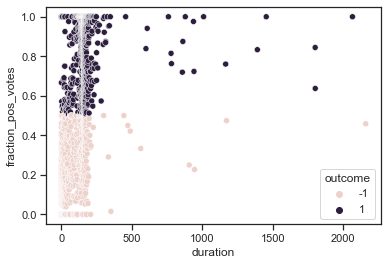

In [232]:
sns.scatterplot(x = results.duration, y=  results.fraction_pos_votes, hue = results.outcome)

This plot tells us that most of the elections lasted less than 500 hours. 

In [235]:
results = results[results.duration < 500]
print("The longuest duration considered for an election is now ", max(results.duration), "hours")

The longuest duration considered for an election is now  488.45 hours


<AxesSubplot:xlabel='duration', ylabel='fraction_pos_votes'>

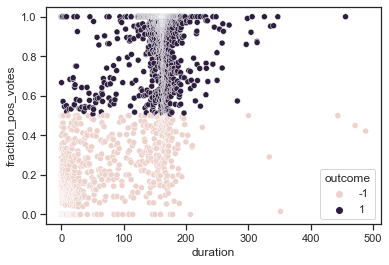

In [236]:
sns.scatterplot(x = results.duration, y = results.fraction_pos_votes, hue = results.outcome)

199.83


<AxesSubplot:xlabel='duration', ylabel='fraction_pos_votes'>

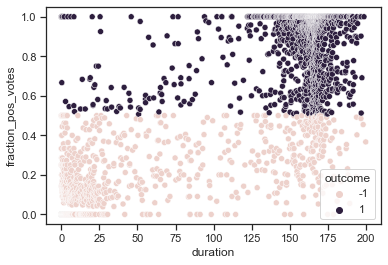

In [256]:
results = results[results.duration < 200]
print(max(results.duration))
#plt.scatter(results.duration, results.fraction_pos_votes)
sns.scatterplot( x= results.duration, y = results.fraction_pos_votes, hue = results.outcome)

The longuest duration considered for an election is now  199.83 hours


<AxesSubplot:xlabel='duration', ylabel='fraction_pos_votes'>

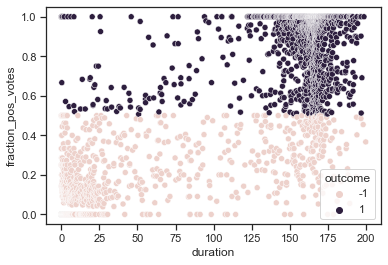

In [257]:
results = results[results.duration < 200]
print("The longuest duration considered for an election is now ", max(results.duration), "hours")
sns.scatterplot( x= results.duration, y = results.fraction_pos_votes, hue = results.outcome)#, style = results.duration)

Finally, we can begin to see 2 clusters. On the top right of the graph, the first cluster corresponds to elections that lasted for a long amount of time, and for which the outcome was positive. On the bottom left, the second cluster corresponds to elections that were short, and for which the outcome was negative.  
This repartition seems to be coherent with the fact that short elections are rather unsuccessful (low success rate, low pos. to neg. votes ratio).  
Why is that? Well, because wikipedia bureaucrats who regulate the election process tend to end very negative election early. It is thus very likely that elections displaying a low ratio of positive votes will be closed early, resulting in short, unsuccessful elections.

In [202]:
grouped_duration = results.groupby("duration").count()
grouped_duration.head()
#sns.scatterplot( x= grouped_duration.index, y = grouped_duration.fraction_pos_votes, hue = grouped_duration.outcome)#, style = grouped_duration.count())

,fraction_pos_votes,outcome
duration,,
0.016667,2,2
0.033333,6,6
0.050000,6,6
0.066667,10,10
0.083333,9,9


In [241]:
grouped_duration = results.drop(["fraction_pos_votes"], axis = 1).groupby("duration")
grouped_duration.head()


,duration,outcome
616,0.02,-1
622,0.02,-1
563,0.03,-1
2082,0.03,-1
2653,0.03,-1
...,...,...
900,196.95,1
2023,197.35,1
1370,198.15,-1
1795,198.72,1


In [194]:
#grouped_duration = grouped_duration.count()
#grouped_duration.head()

,outcome
duration,
0.016667,2
0.033333,6
0.050000,6
0.066667,10
0.083333,9


In [253]:
len(grouped_duration)

1832

In [249]:
# fraction of elections with positive outcomes w.r.t their duration
ratios = []
durations_list = []
for duration, df in grouped_duration:
    #print(duration)
    #print(df)
    nb_elections = len(df.outcome) 
    durations_list.append(duration)
    ratios.append( len(df[df["outcome"]==1] )/ nb_elections ) 

duration_outcome = pd.DataFrame(columns = ["duration", "ratio"])
duration_outcome.duration= durations_list
duration_outcome.ratio = ratios

In [250]:
duration_outcome.head()

,duration,ratio
0,0.02,0.000000
1,0.03,0.000000
2,0.05,0.000000
3,0.07,0.000000
4,0.08,0.222222


<AxesSubplot:xlabel='duration', ylabel='ratio'>

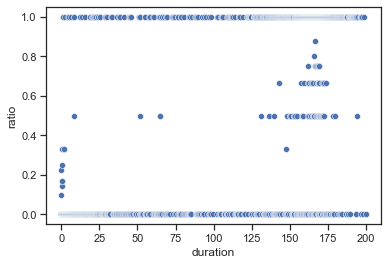

In [252]:
sns.scatterplot(x = duration_outcome.duration, y = duration_outcome.ratio)#, data = grouped_duration)#, hue = results.outcome)

Lets focus on the elections that have equal durations but different outcomes, and see if some patterns can be identified.

<AxesSubplot:xlabel='duration', ylabel='ratio'>

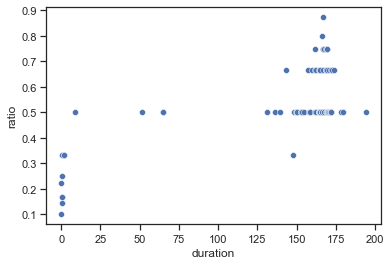

In [255]:
duration_outcome = duration_outcome[duration_outcome.ratio != 0.0]
duration_outcome = duration_outcome[duration_outcome.ratio != 1.0]
sns.scatterplot(x = duration_outcome.duration, y = duration_outcome.ratio)#, data = grouped_duration)#, hue = results.outcome)

Indeed, we once again find the same pattern that we previously observed : the shorter elections are correlated with lower ratios of positive outcome, and inversly, longer elections are correlated with higher ratios of positive outcomes. 

## TIME (in hours)

This time, we will analyse the evolution of the votes throughout an election.

Thus, the x-axis will span from the first seconds after the election started to the last seconds before the election was closed.



Below, we produce 3 plots, of increasing difficulty.

1. one election, on one plot

On the y-axis: the ratio of + to - votes for that election


2. all elections, on one plot

On the y-axis: the ratio of + to - votes

The plot will be composed of many lines, of different length (as the different election did not last for the same amount of time)

The lines will be colored in either of two colors, according the the election outcome. We may find nice trends :)


3. all elections, on one plot, by saving ink

The plot 2 was a bit messy... To save a bit of ink and increase the readibility of the plot, we will plot the mean ratio of + to - votes on the y axis, for the successful elections (in one color), and unsuccessful elections (in another color).

We will also add a boostraped confidence interval to quantifiy the error.

We may identify interesting findings

#TODO

In [30]:
#create dataframe with only positive respectively negative votes
pos_votes = wikipedia[wikipedia['vote'].apply(lambda x: x==1)]
neg_votes = wikipedia[wikipedia['vote'].apply(lambda x: x==-1)]
#TODO: figure out how we handle the neutral votes for all of this

#create dataframe with only succeeded respectively failed elections
pos_election = wikipedia[wikipedia['elec_outcome'].apply(lambda x: x==1)]
neg_election = wikipedia[wikipedia['elec_outcome'].apply(lambda x: x==0)]

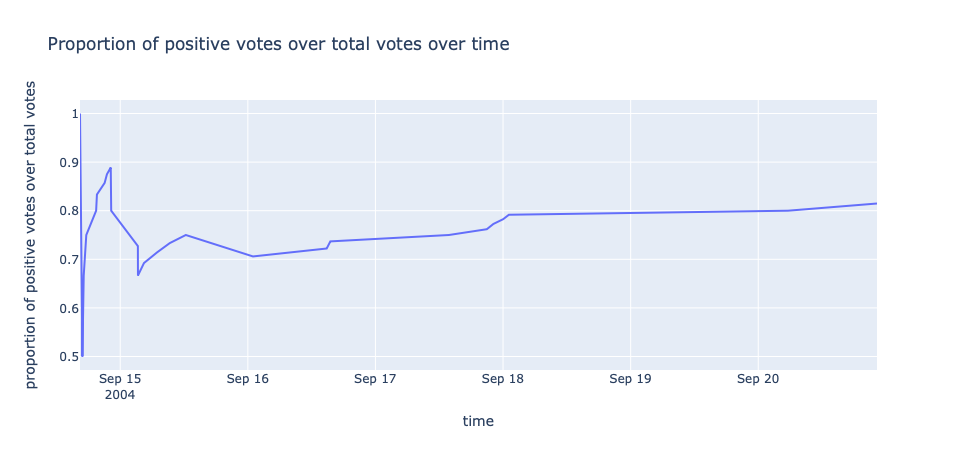

In [31]:
#PLOT 1: graph for the first election
first_candidate_id = wikipedia['candidate_id'][0]
first_election = wikipedia[wikipedia['candidate_id']==first_candidate_id]

#VERSION FRAC
frac=[]
pos_counter=0
for i in range(len(first_election)):
    if (first_election['vote'][i]==1):
        pos_counter += 1 
    frac.append( pos_counter/(i+1))

fig=go.Figure()

fig.add_trace(go.Scatter(
    x= first_election['vote_time'],
    y= frac,
    mode="lines",
    name="proportion of positive votes over total votes until this time instant",
    hovertemplate =
    '<br><b>Date </b>: %{x}'+
    '<br><b>Fraction of positive votes </b>: %{y:.2f}'
))

fig.update_layout(
    title="Proportion of positive votes over total votes over time",
    xaxis_title="time",
    yaxis_title="proportion of positive votes over total votes")
fig.show()

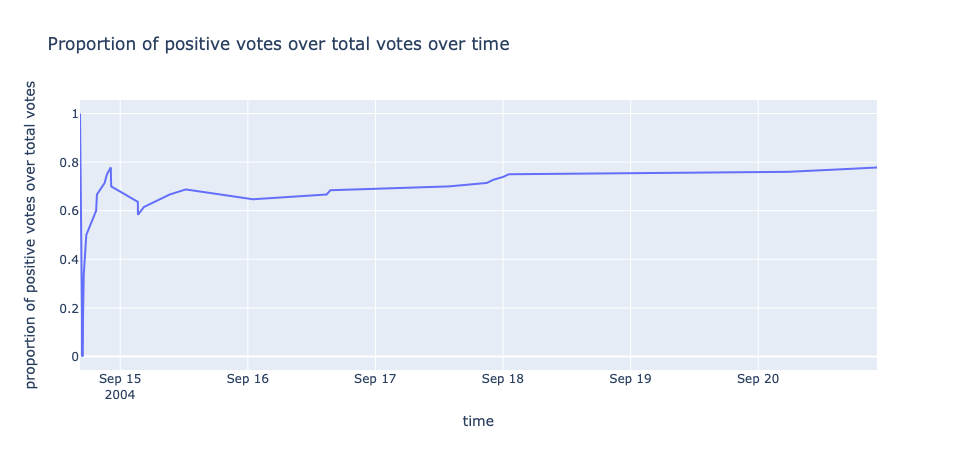

In [32]:
#VERSION VOTE MOYEN
frac=[]
summed=0
for i in range(len(first_election)):
    summed += first_election['vote'][i]
    frac.append( summed/(i+1))
    

fig=go.Figure()

fig.add_trace(go.Scatter(
    x= first_election['vote_time'],
    y= frac,
    mode="lines",
    name="proportion of positive votes over total votes until this time instant",
    hovertemplate =
    '<br><b>Date </b>: %{x}'+
    '<br><b>Fraction of positive votes </b>: %{y:.2f}'
))

fig.update_layout(
    title="Proportion of positive votes over total votes over time",
    xaxis_title="time",
    yaxis_title="proportion of positive votes over total votes")
fig.show()

In [33]:
#PLOT 2: graph for all elections, election outcome as hue 

#first_candidate_id = wikipedia['candidate_id'][0]
#first_election = wikipedia[wikipedia['candidate_id']==first_candidate_id]

def fraction_calculator(df):
    frac=[]
    pos_counter=0
    for i in range(len(df)):
        if (df['vote'][i]==1):
            pos_counter += 1 
        frac.append( pos_counter/(i+1))
    return frac

def plot_trace_frac(x,y, chosen_color):
    fig.add_trace(go.Scatter(
        x= x, #first_election['vote_time']
        y= y, #frac
        mode="lines",
        line = dict(color = chosen_color),
        name="proportion of positive votes over total votes until this time instant",
        hovertemplate =
        '<br><b>Date </b>: %{x}'+
        '<br><b>Fraction of positive votes </b>: %{y:.2f}'
    ))

def plot_by_time(df, chosen_color):

    grouped_by_candidate = df.groupby("candidate_id") #pas la bonne façon de faire
    for i in range((grouped_by_candidate.count())):
        current_election = grouped_by_candidate.get_group(i)
        x_, y_ = fraction_calculator(current_election) #current_election being a df 
        plot_trace_frac(x_ ,y_ , chosen_color)

    fig.update_layout(
        title="Proportion of positive votes over total votes over time",
        xaxis_title="time",
        yaxis_title="proportion of positive votes over total votes")



fig=go.Figure()
#election outcome determines color of traces, successful elections will be depicted in red 
plot_by_time(pos_election, 'rgb(200, 0, 0)') 
#failed elections will be depicted in blue 
plot_by_time(neg_election, 'rgb(0, 0, 200)')

fig.show()

TypeError: 'DataFrame' object cannot be interpreted as an integer

In [ ]:
pos_election.head()
#print(pos_election.groupby(pd.Grouper(key="candidate_id")))
#print(pos_election.groupby(pos_election['candidate_id']).__iter__())
grouped_by_candidate = pos_election.groupby("candidate_id")
grouped_by_candidate.count().head()

# Duplicates 
We want to investigate the vote distributions for repeated elections, meaning when the same candidate seeks adminship several times. For this to be possible, we have to chack that we indeed have enough duplicates in our dataset in order to conduct a meaningful analysis.

In [ ]:
wikipedia.head()

In [ ]:
wikipedia.shape

### Overall duplicates

duplicate in this context = when a voter voted for the same candidate several time, through the all data that we have

vote_count = 1 : unique vote, no duplicate over the time-frame of the dataframe
vote_count = 2 : two votes from the same voter to the same candidate, over the time-frame of the dataframe

In [ ]:
duplicates = wikipedia[['voter_id', 'candidate_id', 'vote']].groupby(by=['voter_id', 'candidate_id']).count().rename(columns={'vote':'vote_count'})
duplicates

In [ ]:
# In total, there are >3500 duplicated votes
np.sum(duplicates.vote_count>1)

In [ ]:
# Histo of the duplicates (1= no duplication)
dup_max = max(duplicates.vote_count)
plt.hist(duplicates.vote_count, bins=dup_max-1)
plt.title("Histograms of the duplicated votes")
plt.xticks(range(1, dup_max+1))
plt.xlabel("Multiplicity of duplication")
plt.ylabel("Number of duplicates")
plt.show()

In [ ]:
# Let's use appropriate axes:
plt.hist(duplicates.vote_count, bins=dup_max-1)
plt.title("Histograms of the duplicated votes, log-log scale")
plt.xticks(range(1, dup_max+1))
plt.xlabel("Multiplicity of duplication")
plt.ylabel("Number of duplicates")
plt.xscale('log')
plt.yscale('log')
plt.show()

# we don't have many values of multiplicity 
# but it does look like the distribution of the multiplicity of duplicates follows a power law

# Interpretation:
# More than 3000 people voted at least 2 times for the same candidate
# Above 200 people voted at least 3 times for the same candidate

### Election-specific duplicates

duplicate in this context = when a voter voted for the same candidate several time during the same election,
i.e., the voter changed its mind

vote_count = 1 : unique vote, no duplicate for a given election
vote_count = 2 : two votes from the same voter to the same candidate at the same election

In [ ]:
duplicates_elec = wikipedia[['elec_time', 'voter_id', 'candidate_id', 'vote']].groupby(by=['elec_time', 'voter_id', 'candidate_id']).count().rename(columns={'vote':'vote_count'})
duplicates_elec

In [ ]:
# In total, there are >3500 duplicated votes
np.sum(duplicates_elec.vote_count>1)
#TODO: investigate
# either: it is not possible to change its mind: we're able to vote only a single time
# or: it is possible to change its mind, but only the latest vote is taken into account (ie only the latest vote is in the dataframe)

# Analysis of Neutral votes 

What can the number/proportion of neutral votes can tell us about the ongoing election ? 
- can the proportion of neutral vote be correlated with a specific outcome ? 
- can the proportion of neutral votes be correlated with a specific duration of election ? 

### Neutral votes and outcome of the election 

In [9]:
wikipedia.head()
wikipedia.elec_outcome.unique()

array([1, 0], dtype=int64)

In [10]:
neutral_analysis = wikipedia[["elec_time", "vote", "elec_outcome"]].groupby("elec_time")

prop_neutral_votes = []
outcome = []

for election, df in neutral_analysis :
    prop_neutral_votes.append(len(df[df["vote"] == 0]) / len(df))
    outcome.append(df.iloc[0]["elec_outcome"])

neutral_outcome = pd.DataFrame(columns = ["prop_neutral", "outcome"])
neutral_outcome.prop_neutral = prop_neutral_votes 
neutral_outcome.outcome = outcome

In [11]:
neutral_outcome.head()

,prop_neutral,outcome
0,0.176471,1
1,0.090909,1
2,0.148148,1
3,0.000000,1
4,0.000000,1


In [12]:
neutral_outcome.sort_values("prop_neutral")

,prop_neutral,outcome
1396,0.0,1
2584,0.0,1
2030,0.0,1
969,0.0,1
968,0.0,1
...,...,...
2538,1.0,0
2742,1.0,0
2532,1.0,0
407,1.0,0


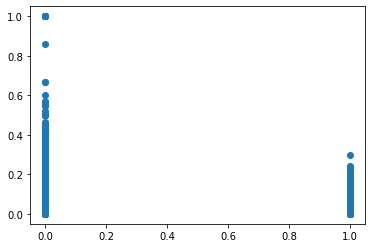

In [13]:
plt.scatter(neutral_outcome.outcome, neutral_outcome.prop_neutral)
plt.show()

In [14]:
zeros_neutral = neutral_outcome[neutral_outcome.prop_neutral==0]
len(zeros_neutral)
len(zeros_neutral[zeros_neutral.outcome == 1])/len(zeros_neutral)

0.5380228136882129

When there is no neutral votes casted, there is roughly a 50 percent chance that the election outcome is postive.  
Let's now drop those elections with zero neutral votes and visualize the influence of proportion of neutral votes on the election outcome.

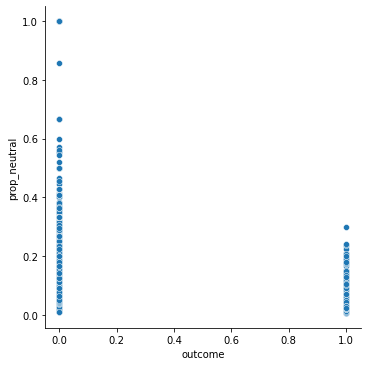

In [15]:
neutral = neutral_outcome[neutral_outcome.prop_neutral!=0]
sns.relplot(x = neutral.outcome, y= neutral.prop_neutral)

There are a lot of elections, a lot of different proportions, we cannot see much on this plot. Let's try to round the proportion to 3 decimals, group by proportion of neutral votes and see what happens. 

In [16]:
neutral.prop_neutral = neutral.prop_neutral.apply(lambda x: round(x, 3))
neutral.sample(5)

C:\Users\eugch\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,prop_neutral,outcome
486,0.133,0
879,0.100,0
1850,0.038,1
2200,0.222,0
1613,0.065,1


In [17]:
print(len(neutral), len(neutral.groupby("prop_neutral")))

1741 271


In [18]:
neutral_pos_outcome = neutral[neutral.outcome==1]
neutral_neg_outcome = neutral[neutral.outcome==0]

neutral_pos_outcome = neutral_pos_outcome.groupby("prop_neutral").count()
neutral_neg_outcome = neutral_neg_outcome.groupby("prop_neutral").count()

neutral_pos_outcome.rename(columns = {'outcome':'Count'}, inplace = True) 
neutral_neg_outcome.rename(columns = {'outcome':'Count'}, inplace = True) 

In [19]:
neutral_pos_outcome.head()

,Count
prop_neutral,
0.006,2
0.007,1
0.008,2
0.009,7
0.010,4


Text(0.5, 1.0, 'outcome positive')

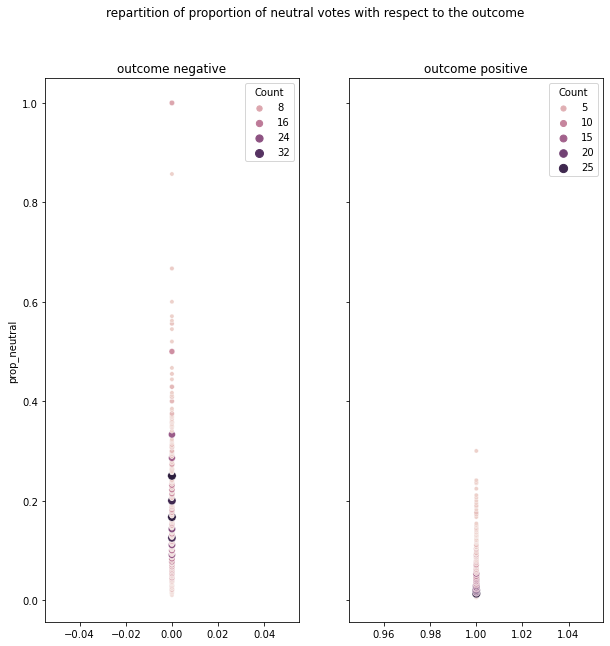

In [32]:
fig, axes = plt.subplots(1, 2,  sharey=True, figsize=(10, 10) )
fig.suptitle('repartition of proportion of neutral votes with respect to the outcome')

sns.scatterplot(ax=axes[0], x =0, y=neutral_neg_outcome.index, hue = neutral_neg_outcome.Count, size=neutral_neg_outcome.Count)
axes[0].set_title("outcome negative")

sns.scatterplot(ax=axes[1], x =1, y=neutral_pos_outcome.index, hue = neutral_pos_outcome.Count, size=neutral_pos_outcome.Count)
axes[1].set_title("outcome positive")

Interpretation : Neutral votes more numerous are correlated with a negative outcome election. 

### Neutral votes and duration of the elections

In [49]:
grouped_wiki.head()

,elec_outcome,elec_time,candidate_id,voter_id,vote,vote_time,nominator_id
0,1,2004-09-21 01:15:53,30,3,1,2004-09-14 16:26:00,32
1,1,2004-09-21 01:15:53,30,25,-1,2004-09-14 16:53:00,32
2,1,2004-09-21 01:15:53,30,4,1,2004-09-14 17:08:00,32
3,1,2004-09-21 01:15:53,30,5,1,2004-09-14 17:37:00,32
4,1,2004-09-21 01:15:53,30,6,1,2004-09-14 19:28:00,32
...,...,...,...,...,...,...,...
114034,0,2008-01-06 01:14:38,6307,5800,-1,2008-01-05 23:31:00,-1
114035,0,2008-01-06 01:14:38,6307,8045,-1,2008-01-05 23:34:00,-1
114036,0,2008-01-06 01:14:38,6307,7053,-1,2008-01-05 23:36:00,-1
114037,0,2008-01-06 01:14:38,6307,6885,-1,2008-01-06 00:44:00,-1


In [52]:
results = pd.DataFrame(columns = ["duration", "prop_neutral_votes", "outcome"])
results.head()

durations_ = []
fractions_neutral_votes = []
outcomes = []
for time, group in grouped_wiki: 
    if len(group["vote"]) == 0 :
        print("empty election")
    duration = (max(group["vote_time"]) - min(group["vote_time"])).total_seconds()
    if duration !=0.0 :
        if (len(group[group["vote"]==0]) != 0)  : 
            fraction_neutral_votes = len(group[group["vote"]==0]) / len(group["vote"])
        else : 
            # if no negative votes votes were casted, we consider the fraction of positive votes to be 1
            fraction_neutral_votes = 0.0
            
        # duration is stored in the number of hours it lasted, with 2 decimals.
        # we consider this precision is enough in order to draw analysis based on comparison of the elections durations.
        durations_.append(round(duration/3600.0, 2) )
        fractions_neutral_votes.append(fraction_neutral_votes)
        outcomes.append(group.iloc[0]["elec_outcome"])


results["duration"] = durations_
results["prop_neutral_votes"] = fractions_neutral_votes
results["outcome"] = outcomes
results.head()

,duration,prop_neutral_votes,outcome
0,167.90,0.176471,1
1,150.53,0.090909,1
2,149.90,0.148148,1
3,155.27,0.000000,1
4,162.98,0.000000,1


<AxesSubplot:xlabel='duration', ylabel='prop_neutral_votes'>

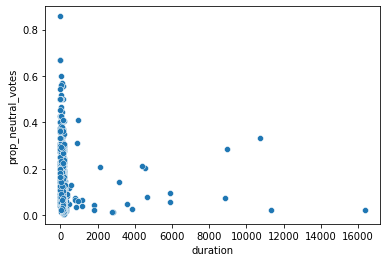

In [55]:
neutral_duration = results[results.prop_neutral_votes!=0]
sns.scatterplot(x = neutral_duration.duration, y= neutral_duration.prop_neutral_votes)

In [56]:
neutral_duration.head()

,duration,prop_neutral_votes,outcome
0,167.90,0.176471,1
1,150.53,0.090909,1
2,149.90,0.148148,1
5,187.00,0.055556,0
7,168.43,0.058824,1


<AxesSubplot:xlabel='duration', ylabel='prop_neutral_votes'>

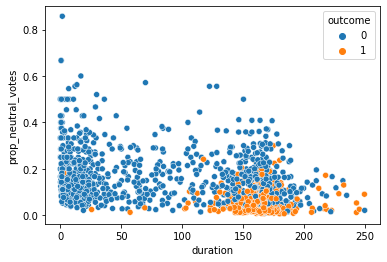

In [57]:
neutral_duration_cropped = neutral_duration[neutral_duration.duration<=250]
sns.scatterplot(x = neutral_duration_cropped.duration, y= neutral_duration_cropped.prop_neutral_votes, hue = neutral_duration_cropped.outcome)

Interpretation : Duration does not seems to be correlated with a specific pattern of proportion of neutral votes ???